# Amazon Review Dataset

## Package Loading and Imports

### Install Rust (necessary for OpenAI)

In [1]:
import os

!curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh -s -- -y

# Check if successful: 
!rustc --version

# Define Rust's default installation path
rust_path = os.path.expanduser('~/.cargo/bin')

# Add Rust to the PATH environment variable
os.environ['PATH'] += os.pathsep + rust_path

# Check if the PATH is set correctly by printing it
print(os.environ['PATH'])

info: downloading installer
info: profile set to 'default'
info: default host triple is x86_64-unknown-linux-gnu
info: syncing channel updates for 'stable-x86_64-unknown-linux-gnu'
info: latest update on 2024-05-02, rust version 1.78.0 (9b00956e5 2024-04-29)
info: downloading component 'cargo'
info: downloading component 'clippy'
info: downloading component 'rust-docs'
info: downloading component 'rust-std'
info: downloading component 'rustc'
 63.7 MiB /  63.7 MiB (100 %)  50.5 MiB/s in  1s ETA:  0s
info: downloading component 'rustfmt'
info: installing component 'cargo'
info: installing component 'clippy'
info: installing component 'rust-docs'
 15.1 MiB /  15.1 MiB (100 %)   4.0 MiB/s in  3s ETA:  0s
info: installing component 'rust-std'
 24.3 MiB /  24.3 MiB (100 %)  11.0 MiB/s in  2s ETA:  0s
info: installing component 'rustc'
 63.7 MiB /  63.7 MiB (100 %)  12.2 MiB/s in  5s ETA:  0s
info: installing component 'rustfmt'
info: default toolchain set to 'stable-x86_64-unknown-linux-gnu

### Download packages that are not pre-installed

In [ ]:
# Packages:
#!pip install google-cloud-storage
#!pip install tensorflow
#!pip install openai

### Import relevant packages

In [380]:
from google.cloud import storage
from io import StringIO
import openai
import html
import re
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Spark Session and Kafka setup

In [381]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit


# Initialize Spark Session

spark = SparkSession.builder \
    .appName("SparkS") \
    .getOrCreate()

## Load Data Sets from Repository into Bucket

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed

# Initialize GCS Client
client = storage.Client()
bucket = client.get_bucket('st446-project-bucket')

datasets_to_get = ['Magazine_Subscriptions.jsonl.gz', 'Appliances.jsonl.gz', 'Video_Games.jsonl.gz']
url_base = 'https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_2023/raw/review_categories/'

def download_and_upload(dataset):
    # Download the data
    response = requests.get(f"{url_base}{dataset}", verify=False)
    data = response.content

    # Create a new blob and upload the data
    blob = bucket.blob(dataset)
    blob.upload_from_string(data)
    return f"Uploaded {dataset} to GCS bucket."

# Use ThreadPoolExecutor to perform downloads and uploads concurrently
with ThreadPoolExecutor(max_workers=len(datasets_to_get)) as executor:
    futures = [executor.submit(download_and_upload, dataset) for dataset in datasets_to_get]
    for future in as_completed(futures):
        print(future.result())
        
print("COMPLETED CELL")

## Load Reviews from Bucket into Data Frame

In [56]:
# Google Cloud Storage bucket path
bucket_path = "gs://st446-project-bucket"

# Names of the datasets to load
datasets = ['Magazine_Subscriptions.jsonl.gz', 'Appliances.jsonl.gz', 'Video_Games.jsonl.gz']

# Function to load and tag a dataset
def load_dataset(file_name):
    # Full path to the dataset
    path = f"{bucket_path}/{file_name}"
    
    # Read the JSON Lines file directly using Spark
    df = spark.read.json(path)
    
    # Add a source column to identify the dataset
    source_tag = file_name.replace('.jsonl.gz', '')  # Removing the file extension for the source tag
    df = df.withColumn("review_category", lit(source_tag))
    print(f"Done with {file_name}")
    return df

# Load all datasets and combine them
data_frames = [load_dataset(dataset) for dataset in datasets]
combined_df = data_frames[0]
for df in data_frames[1:]:
    combined_df = combined_df.unionByName(df)


# Show the first few rows of the combined DataFrame with source column
combined_df.show(5)

print("COMPLETED CELL")

Done with Magazine_Subscriptions.jsonl.gz
Done with Appliances.jsonl.gz
Done with Video_Games.jsonl.gz
+----------+------------+------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+--------------------+
|      asin|helpful_vote|images|parent_asin|rating|                text|    timestamp|               title|             user_id|verified_purchase|     review_category|
+----------+------------+------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+--------------------+
|B00HLSSQKK|           0|    []| B00HLSSQKK|   5.0|Wonderful recipes...|1608046142433|Great pictures an...|AE7Y5RLYIKHOZB5NK...|             true|Magazine_Subscrip...|
|B002PXW04Y|           1|    []| B002PXW04Y|   4.0|Great sports maga...|1470972512000|great for kids wh...|AHORTSSMI6ZZFUFWM...|             true|Magazine_Subscrip...|
|B00HCR5090|           4|    []| B00HCR5090|   5.0|"Joy o

### Drop unnecessary columns

In [121]:
# Dropping multiple columns by passing a list of column names
columns_to_drop = ['images', 'timestamp', 'parent_asin','user_id','verified_purchase']

combined_df = combined_df.drop(*columns_to_drop)

# Show the result
combined_df.show(5)

+----------+------------+------+--------------------+--------------------+--------------------+----------+
|      asin|helpful_vote|rating|                text|               title|     review_category|word_count|
+----------+------------+------+--------------------+--------------------+--------------------+----------+
|B00HLSSQKK|           0|   5.0|Wonderful recipes...|Great pictures an...|Magazine_Subscrip...|         5|
|B002PXW04Y|           1|   4.0|Great sports maga...|great for kids wh...|Magazine_Subscrip...|        10|
|B00HCR5090|           4|   5.0|"Joy of Kosher" m...|A great look at w...|Magazine_Subscrip...|       532|
|B0000ARXXS|           4|   5.0|I've been addicte...|If you enjoy read...|Magazine_Subscrip...|       324|
|B0025ZOVEO|          13|   1.0|       Too many ads!|Too many “ gear a...|Magazine_Subscrip...|         3|
+----------+------------+------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



## Select only Rows of Correct Length

In [122]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import IntegerType

# Define a UDF to count words in the text
def word_count(text):
    if text is None:
        return 0
    return len(text.split())

# Register the UDF with Spark
count_words_udf = udf(word_count, IntegerType())

# Add a word_count column using the UDF
combined_df = combined_df.withColumn("word_count", count_words_udf(col("text")))

# Filter the DataFrame for word count between 150 and 250
filtered_df = combined_df.filter((col("word_count") >= 150) & (col("word_count") <= 250))

print("COMPLETED CELL")

COMPLETED CELL


## Sample ~500 Entries from each Category into a New Data Frame

In [123]:
# Categories to sample from
categories = ['Magazine_Subscriptions', 'Appliances', 'Video_Games']

# Dictionary to hold DataFrames for each category
sampled_dataframes = []
category_counts = {}  # To keep track of counts for each category

for category in categories:
    # Filter the DataFrame for the category
    category_df = filtered_df.filter(col("review_category") == category)
    
    # Check the count and sample if the count is sufficient
    count = category_df.count()
    if count >= 500:
        # Calculate the exact fraction needed for 500 samples
        fraction = min(500.0 / count, 1.0)  # Ensure the fraction is not more than 1
        sampled_df = category_df.sample(withReplacement=False, fraction=fraction, seed=42)
        sampled_dataframes.append(sampled_df)
        sampled_count = sampled_df.count()
        category_counts[category] = sampled_count  # Store the count of sampled items
    else:
        print(f"Not enough data in category {category} to sample 500 items.")
        category_counts[category] = 0  # Indicate no sampling was done

# Union all the sampled DataFrames together, checking if list is not empty
if sampled_dataframes:
    final_sampled_df = sampled_dataframes[0]
    for df in sampled_dataframes[1:]:
        final_sampled_df = final_sampled_df.union(df)

    # Show the results
    final_sampled_df.show(10)
else:
    print("No dataframes were sampled, check your data and category filters.")

# Print the number of samples per category
for category, count in category_counts.items():
    print(f"Number of samples for {category}: {count}")

print("COMPLETED CELL")

+----------+------------+------+--------------------+--------------------+--------------------+----------+
|      asin|helpful_vote|rating|                text|               title|     review_category|word_count|
+----------+------------+------+--------------------+--------------------+--------------------+----------+
|B00005N7R0|          41|   4.0|Islands Magazine ...|Enticing Photography|Magazine_Subscrip...|       176|
|B002PXW13Y|           0|   4.0|I particularly li...|One of the better...|Magazine_Subscrip...|       157|
|B00CY40K3M|           2|   5.0|When I picked up ...|    Very Interesting|Magazine_Subscrip...|       154|
|B00005N7U1|          13|   4.0|Should you try ou...|Health Advice wit...|Magazine_Subscrip...|       239|
|B06XWB4X41|          18|   4.0|I knew when I sub...|I knew what I was...|Magazine_Subscrip...|       192|
|B00005QJE7|           9|   5.0|I have subscribed...|      Addicted to it|Magazine_Subscrip...|       166|
|B00006K3EU|          35|   5.0|This 

## Plot Word Count Distribution for each Category

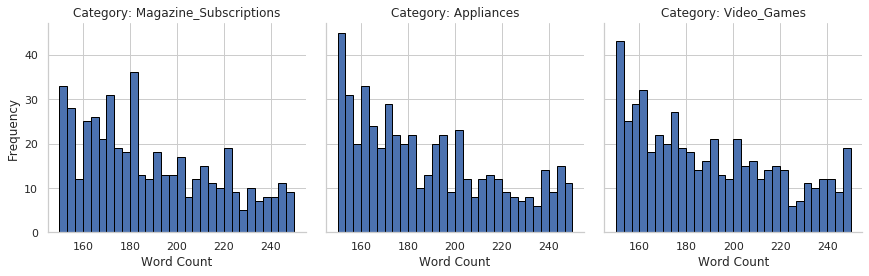

In [124]:

# Convert Spark DataFrame to Pandas DataFrame (ONLY FOR PLOTTING!)

pdf = final_sampled_df.toPandas()

# Set the style of seaborn for better visibility
sns.set(style="whitegrid")

# FacetGrid to plot histograms of word counts by review category
g = sns.FacetGrid(pdf, col="review_category", col_wrap=3, height=4)
g.map(plt.hist, 'word_count', bins=30, color='b', edgecolor='black')

# Setting titles and labels
g.set_titles("Category: {col_name}")
g.set_axis_labels("Word Count", "Frequency")
g.fig.subplots_adjust(top=0.9) 

# Show the plot
plt.show()


## Rewrite Reviews Using LLMs

In [142]:
OPENAI_API_KEY = "removed for security"

### GPT-3.5-turbo-0125

In [143]:
client = openai.OpenAI(api_key=OPENAI_API_KEY)

def rewrite_review_gpt3(original_review):
    # Create the prompt for the API
    prompt = f"Reforumlate the following text in your own words: \"{original_review}\"."

    # Send the request to the OpenAI API using the chat completions endpoint
    response = client.chat.completions.create(
        model="gpt-3.5-turbo-0125",  
        messages=[
            {"role": "user", "content": prompt}
        ],
        max_tokens=256,
        temperature=1,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None
    )
   
    return response.choices[0].message.content

### GPT-4-turbo

In [144]:
client = openai.OpenAI(api_key=OPENAI_API_KEY)

def rewrite_review_gpt4(original_review):
    # Create the prompt for the API
    prompt = f"Reforumlate the following text in your own words: \"{original_review}\"."

    # Send the request to the OpenAI API using the chat completions endpoint
    response = client.chat.completions.create(
        model="gpt-4-turbo",  
        messages=[
            {"role": "user", "content": prompt}
        ],
        max_tokens=256,
        temperature=1,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None 
    )
    return response.choices[0].message.content
   

### Apply Functions to (human) reviews to generate LM content

Performing OpenAI API calls in a distributed manner using Spark poses significant challenges, primarily due to the overhead of managing network calls across multiple nodes. Each executor node in Spark needs to independently make HTTP requests to the OpenAI API, which can lead to inefficiencies such as increased latency, higher risk of failure, and potential bottlenecks in network bandwidth. Moreover, handling and debugging errors across different nodes can complicate the maintenance and monitoring of the application. Given these complexities and the fact that each API call incurs cost, using a non-distributed approach like a pandas DataFrame becomes a practical choice. By collecting the data into a single machine and using pandas to apply the API call functions, one can ensure a more controlled execution environment. This method simplifies error handling, reduces network overhead, and makes the process of debugging and cost management more manageable. Of course, this is only possible due to the limited data set size. An alternative approach using Kafka and a Flask application is outlined in the appendix of this notebook.

In [ ]:
# Collect data frame as pandas df (only possible due to the limited data size)
collected_df = final_sampled_df.toPandas()

# Apply the API calls locally
collected_df['LM_rewrite3'] = collected_df['text'].apply(rewrite_review_gpt3)

collected_df['LM_rewrite4'] = collected_df['text'].apply(rewrite_review_gpt4)
collected_df.head()


In [ ]:

# Define the schema to transform back to a spark df
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, LongType, FloatType

schema = StructType([
    StructField("asin", StringType(), True),            
    StructField("helpful_vote", IntegerType(), True),   
    StructField("rating", FloatType(), True),         
    StructField("text", StringType(), True),            
    StructField("title", StringType(), True),          
    StructField("review_category", StringType(), True), 
    StructField("word_count", IntegerType(), True),
    StructField("LM_rewrite3", StringType(), True),
    StructField("LM_rewrite4", StringType(), True)
])


# Now create the DataFrame using the defined schema
final_spark_df = spark.createDataFrame(collected_df, schema=schema)
final_spark_df.show()


## Save Data Frame to Bucket

In [ ]:
# Example path
bucket_path = "gs://st446-project-bucket/api_data/"

# Save the DataFrame in Parquet format
final_spark_df.write.parquet(bucket_path, mode="overwrite")

### Save Data as CSV (for inspection only)

In [ ]:
# Collect DataFrame into a list of Row objects in the driver memory
collected_data_df = content_df.collect()

# Convert to Pandas DataFrame
collected_data_pandas_df = pd.DataFrame(collected_data_df)

# Write to a local CSV file temporarily
collected_data_pandas_df.to_csv('/tmp/collected_data_pandas_df.csv', index=False)

## Reload Data from Bucket when Needed

In [383]:
data_path = "gs://st446-project-bucket/api_data/"

# Load the Parquet file into a DataFrame
content_df = spark.read.parquet(data_path)

# Show some data to confirm it's loaded
content_df.show(10)

+----------+------------+------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+
|      asin|helpful_vote|rating|                text|               title|     review_category|word_count|         LM_rewrite3|         LM_rewrite4|
+----------+------------+------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+
|B00005N7R0|          41|   4.0|Islands Magazine ...|Enticing Photography|Magazine_Subscrip...|       176|Islands Magazine ...|Islands Magazine ...|
|B002PXW13Y|           0|   4.0|I particularly li...|One of the better...|Magazine_Subscrip...|       157|I really like how...|I particularly ap...|
|B00CY40K3M|           2|   5.0|When I picked up ...|    Very Interesting|Magazine_Subscrip...|       154|I was fascinated ...|When I picked up ...|
|B00005N7U1|          13|   4.0|Should you try ou...|Health Advice wit...|Magazine_Subscrip...|       239|

## Prepare Data for Classifier Models

### Clean input text (human text and LM text)

In [384]:
column_names = content_df.columns

# Print the column names
print("Column names:", column_names)

Column names: ['asin', 'helpful_vote', 'rating', 'text', 'title', 'review_category', 'word_count', 'LM_rewrite3', 'LM_rewrite4']


In [385]:
import html
import re
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.functions import monotonically_increasing_id

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Text Cleaning") \
    .getOrCreate()

# Define the cleaning function
def clean_text(text):
    text = html.unescape(text)
    text = re.sub(r'<br\s*/?>', '\n', text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'([.!?])', r'\1 ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'"+', '"', text)
    return text.strip()

# Register the function as a UDF
clean_text_udf = udf(clean_text, StringType())

# Apply the UDF
content_df = content_df.withColumn("text", clean_text_udf(content_df["text"]))
content_df = content_df.withColumn("LM_rewrite3", clean_text_udf(content_df["LM_rewrite3"]))
content_df = content_df.withColumn("LM_rewrite4", clean_text_udf(content_df["LM_rewrite4"]))
content_df = content_df.withColumn("id", monotonically_increasing_id())


# Show results
content_df.show(5)


+----------+------------+------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+---+
|      asin|helpful_vote|rating|                text|               title|     review_category|word_count|         LM_rewrite3|         LM_rewrite4| id|
+----------+------------+------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+---+
|B00005N7R0|          41|   4.0|Islands Magazine ...|Enticing Photography|Magazine_Subscrip...|       176|Islands Magazine ...|Islands Magazine ...|  0|
|B002PXW13Y|           0|   4.0|I particularly li...|One of the better...|Magazine_Subscrip...|       157|I really like how...|I particularly ap...|  1|
|B00CY40K3M|           2|   5.0|When I picked up ...|    Very Interesting|Magazine_Subscrip...|       154|I was fascinated ...|When I picked up ...|  2|
|B00005N7U1|          13|   4.0|Should you try ou...|Health Advice wit...|Magazine

### Reshape data frame so it has a 'label' column

In [386]:
from pyspark.sql.functions import col, lit


# Create DataFrame for human text with numeric label '0'
human_df = content_df.select(
    col("text").alias("text"),
    lit(0).alias("label"),  # Set label to 0 for human
    "title",
    "id",
    "word_count",
    "review_category"
)

In [387]:
# Create DataFrame for LM text with numeric label '1'
lm_df3 = content_df.select(
    col("LM_rewrite3").alias("text"),
    lit(1).alias("label"),  # Set label to 1 for LM
    "title",
    "id",
    "word_count",
    "review_category"
)

# Union the human and LM DataFrames for GPT3.5 and GPT4
stacked_df3 = human_df.union(lm_df3)


# Show the first 5 rows to confirm
stacked_df3.show(5)

+--------------------+-----+--------------------+---+----------+--------------------+
|                text|label|               title| id|word_count|     review_category|
+--------------------+-----+--------------------+---+----------+--------------------+
|Islands Magazine ...|    0|Enticing Photography|  0|       176|Magazine_Subscrip...|
|I particularly li...|    0|One of the better...|  1|       157|Magazine_Subscrip...|
|When I picked up ...|    0|    Very Interesting|  2|       154|Magazine_Subscrip...|
|Should you try ou...|    0|Health Advice wit...|  3|       239|Magazine_Subscrip...|
|I knew when I sub...|    0|I knew what I was...|  4|       192|Magazine_Subscrip...|
+--------------------+-----+--------------------+---+----------+--------------------+
only showing top 5 rows



In [388]:
# Create DataFrame for LM text with numeric label '1'
lm_df4 = content_df.select(
    col("LM_rewrite4").alias("text"),
    lit(1).alias("label"),  # Set label to 1 for LM
    "title",
    "id",
    "word_count",
    "review_category"
)

# Union the human and LM DataFrames for GPT3.5 and GPT4
stacked_df4 = human_df.union(lm_df4)

# Show the first 5 rows to confirm
stacked_df4.show(5)

+--------------------+-----+--------------------+---+----------+--------------------+
|                text|label|               title| id|word_count|     review_category|
+--------------------+-----+--------------------+---+----------+--------------------+
|Islands Magazine ...|    0|Enticing Photography|  0|       176|Magazine_Subscrip...|
|I particularly li...|    0|One of the better...|  1|       157|Magazine_Subscrip...|
|When I picked up ...|    0|    Very Interesting|  2|       154|Magazine_Subscrip...|
|Should you try ou...|    0|Health Advice wit...|  3|       239|Magazine_Subscrip...|
|I knew when I sub...|    0|I knew what I was...|  4|       192|Magazine_Subscrip...|
+--------------------+-----+--------------------+---+----------+--------------------+
only showing top 5 rows



## Models for GPT-3.5 Data

### Imports

In [239]:
import numpy as np
from pyspark.ml.linalg import SparseVector, DenseVector
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.linalg import DenseVector
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from pyspark.ml.evaluation import BinaryClassificationEvaluator

### Pre-Processing for Logistic Model and Decisition Tree

In [ ]:
# Initialize a Tokenizer
tokenizer = Tokenizer(inputCol="text", outputCol="words")

hashing_tf = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=100)

idf = IDF(inputCol="raw_features", outputCol="features")

### Logistic Regression

In [241]:
# Model Selection
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Pipeline Setup
pipeline = Pipeline(stages=[tokenizer, hashing_tf, idf, lr])

# Train-Test Split
train_data, test_data = stacked_df3.randomSplit([0.8, 0.2], seed=42)

print(train_data.count(), test_data.count())

2407 603


In [242]:
# Training
model_lr = pipeline.fit(train_data)

In [243]:
# Evaluation (AUC)
predictions_lr = model_lr.transform(test_data)
evaluator_lr = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
AUC_lr = evaluator_lr.evaluate(predictions_lr)
print(f"AUC: {AUC_lr:.2f}")

AUC: 0.95


In [244]:
# Show some predictions
predictions_lr.select("text", "label", "prediction").show(3)

+--------------------+-----+----------+
|                text|label|prediction|
+--------------------+-----+----------+
|"Minnesota Monthl...|    0|       0.0|
|"Outside" is. . ....|    0|       0.0|
|"Popular Science"...|    0|       1.0|
+--------------------+-----+----------+
only showing top 3 rows



In [245]:
# Correctly handle column references
corrected_predictions = predictions_lr.select(
    predictions_lr['label'].alias("true_label"), 
    predictions_lr['prediction'].alias("predicted_label")
    )

# Count the matches
matches = corrected_predictions.filter(corrected_predictions.true_label == corrected_predictions.predicted_label).count()

# Count the mismatches
mismatches = corrected_predictions.filter(corrected_predictions.true_label != corrected_predictions.predicted_label).count()

total = matches + mismatches
accuracy = matches/total

print(f"Number of matches: {matches}")
print(f"Number of mismatches: {mismatches}")
print(f"Accuracy: {accuracy}")

Number of matches: 534
Number of mismatches: 69
Accuracy: 0.8855721393034826


### Decision Tree

In [246]:
# Define the Decision Tree model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=5)

# Set up the pipeline (including preprocessing from before)
pipeline_dt = Pipeline(stages=[tokenizer, hashing_tf, idf, dt])

# Train the model
dt_model = pipeline_dt.fit(train_data)

In [247]:
# Make predictions
dt_predictions = dt_model.transform(test_data)

In [248]:
# Evaluate the model
dt_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
dt_auc = dt_evaluator.evaluate(dt_predictions)
print(f"Decision Tree Area Under ROC: {dt_auc:.2f}")

Decision Tree Area Under ROC: 0.83


In [249]:
# List to store AUCs
auc_list = []
accuracy_list = []

# Loop through depths 1 to 5
for depth in range(1, 10):
    # Define the Decision Tree model with current depth
    dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=depth)

    # Set up the pipeline (including preprocessing from before)
    pipeline_dt = Pipeline(stages=[tokenizer, hashing_tf, idf, dt])

    # Train the model
    dt_model = pipeline_dt.fit(train_data)

    # Make predictions
    dt_predictions = dt_model.transform(test_data)

    # Evaluate the model
    dt_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
    dt_auc = dt_evaluator.evaluate(dt_predictions)

    # Store AUC
    auc_list.append(dt_auc)
    
    # Correctly handle column references
    corrected_predictions = dt_predictions.select(
        dt_predictions['label'].alias("true_label"), 
        dt_predictions['prediction'].alias("predicted_label")
        )

    # Count the matches
    matches = corrected_predictions.filter(corrected_predictions.true_label == corrected_predictions.predicted_label).count()

    # Count the mismatches
    mismatches = corrected_predictions.filter(corrected_predictions.true_label != corrected_predictions.predicted_label).count()

    total = matches + mismatches
    accuracy = matches/total

    # Store Accuracy
    accuracy_list.append(accuracy)
    print(f"Loop {depth} competed")

Loop 1 competed
Loop 2 competed
Loop 3 competed
Loop 4 competed
Loop 5 competed
Loop 6 competed
Loop 7 competed
Loop 8 competed
Loop 9 competed


In [250]:
print(f"The Area Under ROCs were: {auc_list}")
print(f"The Accuracies were: {accuracy_list}")

The Area Under ROCs were: [0.7161706349206349, 0.7435846560846562, 0.8198467813051147, 0.8179783950617284, 0.8278053350970017, 0.8250496031746032, 0.801168430335097, 0.7873511904761905, 0.7746362433862434]
The Accuracies were: [0.7081260364842454, 0.7678275290215588, 0.7396351575456053, 0.7794361525704809, 0.7678275290215588, 0.7827529021558872, 0.7678275290215588, 0.7595356550580431, 0.7379767827529021]


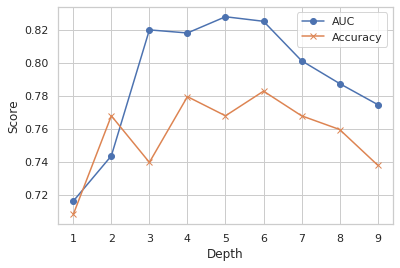

In [251]:
# List of depths (1 to 5)
depths = range(1, 10)

# Plot AUC
plt.plot(depths, auc_list, label='AUC', marker='o')
# Plot Accuracy
plt.plot(depths, accuracy_list, label='Accuracy', marker='x')

# Adding labels and title
plt.xlabel('Depth')
plt.ylabel('Score')
#plt.title('AUC and Accuracy for Decision Trees with Different Depths')
plt.legend()
#plt.grid(True)

# Set integer ticks on the x-axis
plt.xticks(depths)

# Show the plot
plt.show()

### CNN

In [252]:
import tensorflow as tf

In [294]:
# Preprocess the data specifically for CNN
num_features = 1000

input_col = "text"
tokenizer = Tokenizer(inputCol=input_col, outputCol="words")
hashing_tf = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=num_features)
idf = IDF(inputCol="raw_features", outputCol="features")
pipeline = Pipeline(stages=[tokenizer, hashing_tf, idf])
data = pipeline.fit(stacked_df3).transform(stacked_df3)

# Convert vector to list
def to_list(v):
    if isinstance(v, SparseVector):
        return v.toArray().tolist()
    elif isinstance(v, DenseVector):
        return v.tolist()
    else:
        raise TypeError("Unsupported vector type")

In [295]:
# Create UDF with proper return type
to_list_udf = udf(to_list, returnType=ArrayType(FloatType()))
data = data.withColumn("features_list", to_list_udf(data.features))
final_data = data.select("features_list", "label")

# See that the features_list is a single numerical array
data.select("features_list", "features").show(1)

+--------------------+--------------------+
|       features_list|            features|
+--------------------+--------------------+
|[0.0, 0.0, 0.0, 0...|(1000,[18,22,23,3...|
+--------------------+--------------------+
only showing top 1 row



In [296]:
# Use randomSplit to split the data into training and testing sets
train_data, val_data, test_data = final_data.randomSplit([0.8, 0.1 , 0.1], seed=42)

# Convert the training data to NumPy arrays
X_train = np.array(train_data.select("features_list").rdd.flatMap(lambda x: x).collect())
y_train = np.array(train_data.select("label").rdd.flatMap(lambda x: x).collect())

# Convert the training data to NumPy arrays
X_val = np.array(val_data.select("features_list").rdd.flatMap(lambda x: x).collect())
y_val = np.array(val_data.select("label").rdd.flatMap(lambda x: x).collect())

# Convert the testing data to NumPy arrays
X_test = np.array(test_data.select("features_list").rdd.flatMap(lambda x: x).collect())
y_test = np.array(test_data.select("label").rdd.flatMap(lambda x: x).collect())

print(len(X_train), len(X_val), len(X_test))

2407 312 291


In [297]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(num_features,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              metrics=['accuracy'])

In [257]:
# Train the model
EPOCHS = 50
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
76/76 [==============================] - 1s 5ms/step - loss: 0.6593 - accuracy: 0.6032 - val_loss: 0.5310 - val_accuracy: 0.7340
Epoch 2/50
76/76 [==============================] - 0s 3ms/step - loss: 0.4408 - accuracy: 0.8052 - val_loss: 0.3344 - val_accuracy: 0.8590
Epoch 3/50
76/76 [==============================] - 0s 3ms/step - loss: 0.2702 - accuracy: 0.8882 - val_loss: 0.2814 - val_accuracy: 0.8750
Epoch 4/50
76/76 [==============================] - 0s 3ms/step - loss: 0.1764 - accuracy: 0.9323 - val_loss: 0.2652 - val_accuracy: 0.8814
Epoch 5/50
76/76 [==============================] - 0s 3ms/step - loss: 0.1149 - accuracy: 0.9576 - val_loss: 0.2653 - val_accuracy: 0.9006
Epoch 6/50
76/76 [==============================] - 0s 3ms/step - loss: 0.0799 - accuracy: 0.9705 - val_loss: 0.2818 - val_accuracy: 0.8942
Epoch 7/50
76/76 [==============================] - 0s 3ms/step - loss: 0.0532 - accuracy: 0.9830 - val_loss: 0.2956 - val_accuracy: 0.9038
Epoch 8/50
76/76 [==

In [258]:
# Evaluate the model
eval_loss, eval_acc = model.evaluate(X_test, y_test)
print(f"Eval loss: {eval_loss:.4f}, Eval accuracy: {eval_acc:.4f}")

10/10 [==============================] - 0s 2ms/step - loss: 0.1692 - accuracy: 0.9278
Eval loss: 0.1692, Eval accuracy: 0.9278


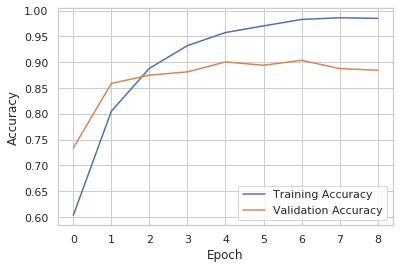

In [259]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


# Save the figure
plt.savefig('model_accuracy.png')

plt.show()

## Models GPT-4 Data

### Pre-Processing for Logistic Model and Decisition Tree

In [298]:
# Initialize a Tokenizer
tokenizer = Tokenizer(inputCol="text", outputCol="words")

hashing_tf = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=100)

idf = IDF(inputCol="raw_features", outputCol="features")

### Logistic Regression

In [299]:
# Model Selection
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Pipeline Setup
pipeline = Pipeline(stages=[tokenizer, hashing_tf, idf, lr])

# Train-Test Split
train_data, test_data = stacked_df4.randomSplit([0.8, 0.2], seed=42)

print(train_data.count(), test_data.count())

2407 603


In [300]:
# Training
model_lr = pipeline.fit(train_data)

In [301]:
# Evaluation (AUC)
predictions_lr = model_lr.transform(test_data)
evaluator_lr = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
AUC_lr = evaluator_lr.evaluate(predictions_lr)
print(f"AUC: {AUC_lr:.2f}")

AUC: 0.94


In [302]:
# Show some predictions
predictions_lr.select("text", "label", "prediction").show(3)

+--------------------+-----+----------+
|                text|label|prediction|
+--------------------+-----+----------+
|"Minnesota Monthl...|    0|       0.0|
|"Outside" is. . ....|    0|       0.0|
|"Popular Science"...|    0|       0.0|
+--------------------+-----+----------+
only showing top 3 rows



In [303]:
# Correctly handle column references
corrected_predictions = predictions_lr.select(
    predictions_lr['label'].alias("true_label"), 
    predictions_lr['prediction'].alias("predicted_label")
    )

# Count the matches
matches = corrected_predictions.filter(corrected_predictions.true_label == corrected_predictions.predicted_label).count()

# Count the mismatches
mismatches = corrected_predictions.filter(corrected_predictions.true_label != corrected_predictions.predicted_label).count()

total = matches + mismatches
accuracy = matches/total

print(f"Number of matches: {matches}")
print(f"Number of mismatches: {mismatches}")
print(f"Accuracy: {accuracy}")

Number of matches: 528
Number of mismatches: 75
Accuracy: 0.8756218905472637


### Decision Tree

In [266]:
# Define the Decision Tree model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=5)

# Set up the pipeline (including preprocessing from before)
pipeline_dt = Pipeline(stages=[tokenizer, hashing_tf, idf, dt])

# Train the model
dt_model = pipeline_dt.fit(train_data)

In [267]:
# Make predictions
dt_predictions = dt_model.transform(test_data)

In [268]:
# Evaluate the model
dt_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
dt_auc = dt_evaluator.evaluate(dt_predictions)
print(f"Decision Tree Area Under ROC: {dt_auc:.2f}")

Decision Tree Area Under ROC: 0.78


In [269]:
# List to store AUCs
auc_list = []
accuracy_list = []

# Loop through depths 1 to 5
for depth in range(1, 10):
    # Define the Decision Tree model with current depth
    dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=depth)

    # Set up the pipeline (including preprocessing from before)
    pipeline_dt = Pipeline(stages=[tokenizer, hashing_tf, idf, dt])

    # Train the model
    dt_model = pipeline_dt.fit(train_data)

    # Make predictions
    dt_predictions = dt_model.transform(test_data)

    # Evaluate the model
    dt_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
    dt_auc = dt_evaluator.evaluate(dt_predictions)

    # Store AUC
    auc_list.append(dt_auc)
    
    # Correctly handle column references
    corrected_predictions = dt_predictions.select(
        dt_predictions['label'].alias("true_label"), 
        dt_predictions['prediction'].alias("predicted_label")
        )

    # Count the matches
    matches = corrected_predictions.filter(corrected_predictions.true_label == corrected_predictions.predicted_label).count()

    # Count the mismatches
    mismatches = corrected_predictions.filter(corrected_predictions.true_label != corrected_predictions.predicted_label).count()

    total = matches + mismatches
    accuracy = matches/total

    # Store Accuracy
    accuracy_list.append(accuracy)
    print(f"Loop {depth} competed")

Loop 1 competed
Loop 2 competed
Loop 3 competed
Loop 4 competed
Loop 5 competed
Loop 6 competed
Loop 7 competed
Loop 8 competed
Loop 9 competed


In [270]:
print(f"The Area Under ROCs were: {auc_list}")
print(f"The Accuracies were: {accuracy_list}")

The Area Under ROCs were: [0.6797123015873016, 0.7253968253968254, 0.6697310405643739, 0.7724592151675485, 0.7826168430335098, 0.8003086419753087, 0.8041280864197531, 0.7864583333333334, 0.7772652116402117]
The Accuracies were: [0.6733001658374793, 0.7330016583747927, 0.7048092868988391, 0.736318407960199, 0.7180762852404643, 0.7545605306799337, 0.7495854063018242, 0.724709784411277, 0.7296849087893864]


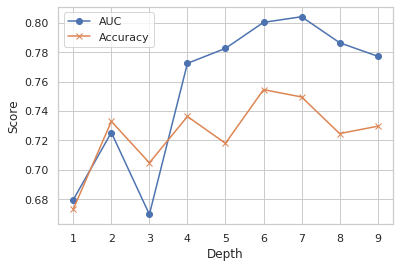

In [271]:
# List of depths (1 to 5)
depths = range(1, 10)

# Plot AUC
plt.plot(depths, auc_list, label='AUC', marker='o')
# Plot Accuracy
plt.plot(depths, accuracy_list, label='Accuracy', marker='x')

# Adding labels and title
plt.xlabel('Depth')
plt.ylabel('Score')
#plt.title('AUC and Accuracy for Decision Trees with Different Depths')
plt.legend()
#plt.grid(True)

# Set integer ticks on the x-axis
plt.xticks(depths)

# Show the plot
plt.show()

### CNN

In [272]:
# Preprocess the data specifically for CNN
num_features = 1000

input_col = "text"
tokenizer = Tokenizer(inputCol=input_col, outputCol="words")
hashing_tf = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=num_features)
idf = IDF(inputCol="raw_features", outputCol="features")
pipeline = Pipeline(stages=[tokenizer, hashing_tf, idf])
data = pipeline.fit(stacked_df4).transform(stacked_df4)

# Convert vector to list
def to_list(v):
    if isinstance(v, SparseVector):
        return v.toArray().tolist()
    elif isinstance(v, DenseVector):
        return v.tolist()
    else:
        raise TypeError("Unsupported vector type")

In [273]:
# Create UDF with proper return type
to_list_udf = udf(to_list, returnType=ArrayType(FloatType()))
data = data.withColumn("features_list", to_list_udf(data.features))
final_data = data.select("features_list", "label")

# See that the features_list is a single numerical array
data.select("features_list", "features").show(1)

+--------------------+--------------------+
|       features_list|            features|
+--------------------+--------------------+
|[0.0, 0.0, 0.0, 0...|(1000,[18,22,23,3...|
+--------------------+--------------------+
only showing top 1 row



In [274]:
# Use randomSplit to split the data into training and testing sets
train_data, val_data, test_data = final_data.randomSplit([0.8, 0.1 , 0.1], seed=42)

# Convert the training data to NumPy arrays
X_train = np.array(train_data.select("features_list").rdd.flatMap(lambda x: x).collect())
y_train = np.array(train_data.select("label").rdd.flatMap(lambda x: x).collect())

# Convert the training data to NumPy arrays
X_val = np.array(val_data.select("features_list").rdd.flatMap(lambda x: x).collect())
y_val = np.array(val_data.select("label").rdd.flatMap(lambda x: x).collect())

# Convert the testing data to NumPy arrays
X_test = np.array(test_data.select("features_list").rdd.flatMap(lambda x: x).collect())
y_test = np.array(test_data.select("label").rdd.flatMap(lambda x: x).collect())

print(len(X_train), len(X_val), len(X_test))

2407 312 291


In [275]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(num_features,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              metrics=['accuracy'])

In [276]:
# Train the model
EPOCHS = 50
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
76/76 [==============================] - 1s 5ms/step - loss: 0.6332 - accuracy: 0.6419 - val_loss: 0.4675 - val_accuracy: 0.7853
Epoch 2/50
76/76 [==============================] - 0s 3ms/step - loss: 0.3299 - accuracy: 0.8687 - val_loss: 0.2126 - val_accuracy: 0.8974
Epoch 3/50
76/76 [==============================] - 0s 3ms/step - loss: 0.1791 - accuracy: 0.9331 - val_loss: 0.1716 - val_accuracy: 0.9295
Epoch 4/50
76/76 [==============================] - 0s 3ms/step - loss: 0.1048 - accuracy: 0.9643 - val_loss: 0.1657 - val_accuracy: 0.9327
Epoch 5/50
76/76 [==============================] - 0s 3ms/step - loss: 0.0789 - accuracy: 0.9713 - val_loss: 0.1801 - val_accuracy: 0.9295
Epoch 6/50
76/76 [==============================] - 0s 3ms/step - loss: 0.0485 - accuracy: 0.9834 - val_loss: 0.2202 - val_accuracy: 0.9295
Epoch 7/50
76/76 [==============================] - 0s 3ms/step - loss: 0.0274 - accuracy: 0.9909 - val_loss: 0.2153 - val_accuracy: 0.9295
Epoch 8/50
76/76 [==

In [279]:
# Evaluate the model
eval_loss, eval_acc = model.evaluate(X_test, y_test)
print(f"Eval loss: {eval_loss:.4f}, Eval accuracy: {eval_acc:.4f}")

10/10 [==============================] - 0s 2ms/step - loss: 0.1508 - accuracy: 0.9485
Eval loss: 0.1508, Eval accuracy: 0.9485


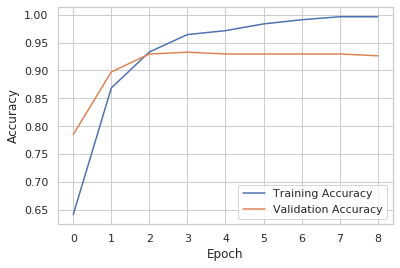

In [280]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


# Save the figure
plt.savefig('model_accuracy.png')

plt.show()

## Further Experiments

### Using GPT-4 as a Classfier

Instead of using our own models, we sample human-written and GPT3-written texts from our dataset, and ask GPT4 to classify it into either human-written or LM-written.

In [389]:
from pyspark.sql.functions import col

# Calculate the count of each label category
label_counts = stacked_df3.groupBy("label").count().collect()

# Create a dictionary of fractions to sample 50 from each label
total_required_samples = 100
samples_per_label = total_required_samples // 2 

fractions = {
    row['label']: samples_per_label / row['count']
    for row in label_counts
}

# Adjust the fractions if they exceed 1
fractions = {k: min(v, 1.0) for k, v in fractions.items()}


In [407]:
sampled_df = stacked_df3.stat.sampleBy("label", fractions, seed=42)


In [408]:
sampled_df.show(5)

+--------------------+-----+--------------------+---+----------+--------------------+
|                text|label|               title| id|word_count|     review_category|
+--------------------+-----+--------------------+---+----------+--------------------+
|This is what SciA...|    0|Has replaced SciA...|  6|       221|Magazine_Subscrip...|
|When I first orde...|    0|Sew Beautiful bab...|101|       171|Magazine_Subscrip...|
|"Wired" is anothe...|    0|T3 = Looks dumb b...|102|       202|Magazine_Subscrip...|
|Whenever I'd fini...|    0|A woman's magazin...|103|       186|Magazine_Subscrip...|
|I was so disappoi...|    0|Why pay just to r...|115|       152|Magazine_Subscrip...|
+--------------------+-----+--------------------+---+----------+--------------------+
only showing top 5 rows



In [409]:
from pyspark.sql.functions import rand

# Shuffle the DataFrame rows randomly
sampled_df = sampled_df.orderBy(rand())

# Show the shuffled DataFrame to verify the results
sampled_df.show(5)


+--------------------+-----+--------------------+----------+----------+--------------------+
|                text|label|               title|        id|word_count|     review_category|
+--------------------+-----+--------------------+----------+----------+--------------------+
|Mine was Listed a...|    0| Really was like new|8589935282|       179|         Video_Games|
|We originally rec...|    0|Highlights DECEIT...|       397|       238|Magazine_Subscrip...|
|Having buyer's re...|    0|Buyer's Remorse -...|       735|       163|          Appliances|
|I bought this mag...|    1|      Spam Spam Spam|       220|       221|Magazine_Subscrip...|
|This is my first ...|    1| Decent coffee maker|8589934637|       218|          Appliances|
+--------------------+-----+--------------------+----------+----------+--------------------+
only showing top 5 rows



In [410]:

sampled_df.groupBy("label").count().show()


+-----+-----+
|label|count|
+-----+-----+
|    1|   53|
|    0|   52|
+-----+-----+



In [413]:
client = openai.OpenAI(api_key=OPENAI_API_KEY)

def classify_text_gpt4(original_review):
    # Create the prompt for the API
    
    prompt = f"You will see a brief product review. The review is either an original human-written review or a human review that has been rewritten by GPT-3.5. Decide whether the review has been rewritten by the language model or not. Output '1' for rewritten and '0' for original. This is the review: \"{original_review}\"."

    response = client.chat.completions.create(
        model="gpt-4-turbo",  
        messages=[
            {"role": "user", "content": prompt}
        ],
        max_tokens=256,
        temperature=1,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None 
    )
   
    return response.choices[0].message.content
   

In [414]:
# Collect data frame as pandas df (only possible due to the limited data size)
collected_sample_test = sampled_df.toPandas()

# Apply the API calls locally
collected_sample_test['classification'] = collected_sample_test['text'].apply(classify_text_gpt4)


In [420]:
collected_sample_test['label'] = collected_sample_test['label'].astype(int)
collected_sample_test['classification'] = collected_sample_test['classification'].astype(int)

collected_sample_test['comparison'] = np.where(collected_sample_test['label'] == collected_sample_test['classification'], 1, 0)

collected_sample_test.head()


,text,label,title,id,word_count,review_category,classification,comparison
0,Mine was Listed as like new. I received the Bo...,0,Really was like new,8589935282,179,Video_Games,0,1
1,We originally received a 1 year subscription a...,0,Highlights DECEITFUL subsciption language,397,238,Magazine_Subscriptions,0,1
2,Having buyer's remorse and wish I had checked ...,0,"Buyer's Remorse - Horrible Rack Design, Dishes...",735,163,Appliances,0,1
3,I bought this magazine and was disappointed wi...,1,Spam Spam Spam,220,221,Magazine_Subscriptions,0,0
4,This is my first non-Keurig coffee maker and w...,1,Decent coffee maker,8589934637,218,Appliances,0,0


In [421]:
accuracy_gpt4 = sum(collected_sample_test['comparison']) / len(collected_sample_test['comparison'])

print(accuracy_gpt4)

0.5523809523809524


In [367]:
#collected_sample.to_csv("collected_sample.csv")

### Testing whether classification performance depends on mean text length

Split the GPT3 dataset into shorter and longer human texts (splitting at the median text length). This results in a df where the texts are on average 165 words long, and one where they are 213 words long.

In [309]:
from pyspark.sql.functions import length, expr, col


# Filter to only include human-generated texts
human_texts = stacked_df3.filter(stacked_df3['label'] == 0)

# Calculate the median text length
median_length = human_texts.approxQuantile("word_count", [0.5], 0.01)[0]


In [314]:
# Dataset for texts with word count shorter or equal to the median
short_texts_df = stacked_df3.filter(stacked_df3['word_count'] <= int(median_length))

# Dataset for texts with word count longer than the median
long_texts_df = stacked_df3.filter(stacked_df3['word_count'] > int(median_length))


In [325]:
from pyspark.sql.functions import mean

# Calculate mean word count for short texts
mean_word_count_short = short_texts_df.agg(mean("word_count").alias("mean_word_count")).show()

# Calculate mean word count for long texts
mean_word_count_long = long_texts_df.agg(mean("word_count").alias("mean_word_count")).show()



+-----------------+
|  mean_word_count|
+-----------------+
|164.7340425531915|
+-----------------+

+-----------------+
|  mean_word_count|
+-----------------+
|213.0199203187251|
+-----------------+



In [315]:
# Show the first few rows of each dataset
short_texts_df.show(5)
long_texts_df.show(5)


+--------------------+-----+--------------------+----------+----------+
|                text|label|               title|      asin|word_count|
+--------------------+-----+--------------------+----------+----------+
|Islands Magazine ...|    0|Enticing Photography|B00005N7R0|       176|
|I particularly li...|    0|One of the better...|B002PXW13Y|       157|
|When I picked up ...|    0|    Very Interesting|B00CY40K3M|       154|
|I have subscribed...|    0|      Addicted to it|B00005QJE7|       166|
|I had a subscript...|    0| Still not very good|B00005NIN8|       164|
+--------------------+-----+--------------------+----------+----------+
only showing top 5 rows

+--------------------+-----+--------------------+----------+----------+
|                text|label|               title|      asin|word_count|
+--------------------+-----+--------------------+----------+----------+
|Should you try ou...|    0|Health Advice wit...|B00005N7U1|       239|
|I knew when I sub...|    0|I knew what

### Testing whether classification accuracy is different for different review categories

Split the GPT3 data set into the three underlying categories and train the model using the split data.

In [331]:
distinct_categories = stacked_df3.select("review_category").distinct()
distinct_categories.show()

+--------------------+
|     review_category|
+--------------------+
|         Video_Games|
|Magazine_Subscrip...|
|          Appliances|
+--------------------+



In [333]:

df_magaz = stacked_df3.filter(stacked_df3['review_category'] == 'Magazine_Subscriptions')
df_applia = stacked_df3.filter(stacked_df3['review_category'] == 'Appliances')
df_games = stacked_df3.filter(stacked_df3['review_category'] == 'Video_Games')


In [334]:
df_magaz.show(3)
df_applia.show(3)
df_games.show(3)

+--------------------+-----+--------------------+----------+----------+--------------------+
|                text|label|               title|      asin|word_count|     review_category|
+--------------------+-----+--------------------+----------+----------+--------------------+
|Islands Magazine ...|    0|Enticing Photography|B00005N7R0|       176|Magazine_Subscrip...|
|I particularly li...|    0|One of the better...|B002PXW13Y|       157|Magazine_Subscrip...|
|When I picked up ...|    0|    Very Interesting|B00CY40K3M|       154|Magazine_Subscrip...|
+--------------------+-----+--------------------+----------+----------+--------------------+
only showing top 3 rows

+--------------------+-----+--------------------+----------+----------+---------------+
|                text|label|               title|      asin|word_count|review_category|
+--------------------+-----+--------------------+----------+----------+---------------+
|I was concerned a...|    0|Perfect for small...|B07B94ZR74|

### Creating a Data Frame that only either contains the LM version or the human version of a text

We do this to see how the model performs when it does not have access to both versions of the text

In [345]:
from pyspark.sql.functions import rand, row_number, col
from pyspark.sql.window import Window

# Add a random value column for randomness in selection
df_r = stacked_df3.withColumn("random", rand())

# Define a window specification partitioned by 'id' and ordered by 'random'
windowSpec = Window.partitionBy("id").orderBy("random")

# Apply row_number over the defined windowSpec
df_r = df_r.withColumn("row_num", row_number().over(windowSpec))

# Filter out only the first row from each window (i.e., partition of 'id')
df_r = df_r.filter(col("row_num") == 1).drop("random", "row_num")


In [347]:
df_r.show(5)

+--------------------+-----+--------------------+----------+----------+--------------------+
|                text|label|               title|        id|word_count|     review_category|
+--------------------+-----+--------------------+----------+----------+--------------------+
|The magazine has ...|    0|Magazine gained a...|        26|       197|Magazine_Subscrip...|
|APR is known for ...|    1|Important publish...|        29|       229|Magazine_Subscrip...|
|I enjoy this maga...|    0|FINALLY A MAGAZIN...|       474|       180|Magazine_Subscrip...|
|I've had this ice...|    1|Wonderful for any...|8589934658|       191|          Appliances|
|While the game pl...|    0|It's just fun, wh...|8589934965|       165|         Video_Games|
+--------------------+-----+--------------------+----------+----------+--------------------+
only showing top 5 rows



In [346]:
df_r.groupBy("label").count().show(5)

+-----+-----+
|label|count|
+-----+-----+
|    1|  737|
|    0|  768|
+-----+-----+



### Logistic Regression Using different Data Sets created datasets from above

In [348]:
# Initialize a Tokenizer
tokenizer = Tokenizer(inputCol="text", outputCol="words")

hashing_tf = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=100)

idf = IDF(inputCol="raw_features", outputCol="features")

In [349]:
# Model Selection
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Pipeline Setup
pipeline = Pipeline(stages=[tokenizer, hashing_tf, idf, lr])

# Train-Test Split
train_data, test_data = df_r.randomSplit([0.8, 0.2], seed=42)

print(train_data.count(), test_data.count())

# Training
model_lr = pipeline.fit(train_data)

# Evaluation (AUC)
predictions_lr = model_lr.transform(test_data)
evaluator_lr = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
AUC_lr = evaluator_lr.evaluate(predictions_lr)
print(f"AUC: {AUC_lr:.2f}")


# Correctly handle column references
corrected_predictions = predictions_lr.select(
    predictions_lr['label'].alias("true_label"), 
    predictions_lr['prediction'].alias("predicted_label")
    )

# Count the matches
matches = corrected_predictions.filter(corrected_predictions.true_label == corrected_predictions.predicted_label).count()

# Count the mismatches
mismatches = corrected_predictions.filter(corrected_predictions.true_label != corrected_predictions.predicted_label).count()

total = matches + mismatches
accuracy = matches/total

print(f"Number of matches: {matches}")
print(f"Number of mismatches: {mismatches}")
print(f"Accuracy: {accuracy}")

1185 320
AUC: 0.95
Number of matches: 279
Number of mismatches: 41
Accuracy: 0.871875


## Text Data Analysis
Comparing text characteristics of human-text, GPT4-generated text and GPT3.5 generated text.

In [281]:
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql import SparkSession
import nltk
from nltk.corpus import stopwords
from collections import Counter

In [282]:
def analyze_text_stats(df, text_col, label_col):
    df = df.withColumn(text_col, F.regexp_replace(F.col(text_col), "\xa0", " "))
    df = df.withColumn("words", F.split(F.trim(F.col(text_col)), " "))

    # Filter out empty strings
    df = df.withColumn("words", F.expr("filter(words, x -> x != '')"))

    # Compute the number of words in each text
    df = df.withColumn("num_words", F.size(F.col("words")))
    
    # Compute the number of sentences in each text
    df = df.withColumn("num_sentences", F.size(F.split(F.col(text_col), r"[.!?]+")))

    # Compute the number of words per sentence in each text
    df = df.withColumn("words_per_sentence", F.col("num_words") / F.col("num_sentences"))

    # Calculate statistics for each label
    def compute_stats(group_df):
        return {
            "average_num_words": group_df.agg(F.mean("num_words")).first()[0],
            "stddev_num_words": group_df.agg(F.stddev("num_words")).first()[0],
            "average_num_sentences": group_df.agg(F.mean("num_sentences")).first()[0],
            "stddev_num_sentences": group_df.agg(F.stddev("num_sentences")).first()[0],
            "average_words_per_sentence": group_df.agg(F.mean("words_per_sentence")).first()[0],
            "stddev_words_per_sentence": group_df.agg(F.stddev("words_per_sentence")).first()[0],
            "label_count": group_df.count()
        }

    result = {}

    for label in df.select(label_col).distinct().collect():
        label_value = label[label_col]
        group_df = df.filter(F.col(label_col) == label_value)

        stats = compute_stats(group_df)

        all_words = group_df.select(F.explode("words").alias("word"))
        stop_words = set(stopwords.words("english"))
        punctuations = set([".", "!", "?", ",", ":", ";", "-", "(", ")", "[", "]", "\"", "\'", "..."])

        all_words = all_words.filter(~F.col("word").isin(stop_words | punctuations) & (F.col("word") != ""))

        word_counts = (
            all_words.groupBy("word").agg(F.count("word").alias("count"))
            .orderBy(F.desc("count"))
            .limit(5)
        )
        common_words = [
            {"word": row["word"], "average_frequency": row["count"] / group_df.count()}
            for row in word_counts.collect()
        ]

        stats["most_common_words"] = common_words

        result[label_value] = stats

    return result

In [283]:
# Call the function
result3 = analyze_text_stats(stacked_df3, "text", "label")

In [284]:
for key, value in result3.items():
    print(f"Label: {key}")
    print("Statistics:")
    for stat_key, stat_value in value.items():
        if isinstance(stat_value, float):
            print(f"  {stat_key}: {round(stat_value, 2)}")
        elif isinstance(stat_value, list):
            rounded_list = [{"word": item["word"], "average_frequency": round(item["average_frequency"], 2)} for item in stat_value]
            print(f"  {stat_key}: {rounded_list}")
        else:
            print(f"  {stat_key}: {stat_value}")

Label: 1
Statistics:
  average_num_words: 127.96
  stddev_num_words: 31.67
  average_num_sentences: 7.95
  stddev_num_sentences: 2.0
  average_words_per_sentence: 16.29
  stddev_words_per_sentence: 2.61
  label_count: 1505
  most_common_words: [{'word': 'I', 'average_frequency': 3.5}, {'word': 'The', 'average_frequency': 1.28}, {'word': 'magazine', 'average_frequency': 0.58}, {'word': 'It', 'average_frequency': 0.47}, {'word': 'like', 'average_frequency': 0.45}]
Label: 0
Statistics:
  average_num_words: 189.19
  stddev_num_words: 28.77
  average_num_sentences: 13.39
  stddev_num_sentences: 5.03
  average_words_per_sentence: 15.91
  stddev_words_per_sentence: 9.3
  label_count: 1505
  most_common_words: [{'word': 'I', 'average_frequency': 5.0}, {'word': 'The', 'average_frequency': 1.19}, {'word': 'like', 'average_frequency': 0.64}, {'word': 'one', 'average_frequency': 0.59}, {'word': 'magazine', 'average_frequency': 0.56}]


In [285]:
# Call the function
result4 = analyze_text_stats(stacked_df4, "text", "label")

In [286]:
for key, value in result4.items():
    print(f"Label: {key}")
    print("Statistics:")
    for stat_key, stat_value in value.items():
        if isinstance(stat_value, float):
            print(f"  {stat_key}: {round(stat_value, 2)}")
        elif isinstance(stat_value, list):
            rounded_list = [{"word": item["word"], "average_frequency": round(item["average_frequency"], 2)} for item in stat_value]
            print(f"  {stat_key}: {rounded_list}")
        else:
            print(f"  {stat_key}: {stat_value}")

Label: 1
Statistics:
  average_num_words: 166.98
  stddev_num_words: 26.49
  average_num_sentences: 10.11
  stddev_num_sentences: 2.04
  average_words_per_sentence: 16.86
  stddev_words_per_sentence: 2.7
  label_count: 1505
  most_common_words: [{'word': 'I', 'average_frequency': 3.53}, {'word': 'The', 'average_frequency': 1.21}, {'word': 'magazine', 'average_frequency': 0.58}, {'word': 'like', 'average_frequency': 0.49}, {'word': 'This', 'average_frequency': 0.46}]
Label: 0
Statistics:
  average_num_words: 189.19
  stddev_num_words: 28.77
  average_num_sentences: 13.39
  stddev_num_sentences: 5.03
  average_words_per_sentence: 15.91
  stddev_words_per_sentence: 9.3
  label_count: 1505
  most_common_words: [{'word': 'I', 'average_frequency': 5.0}, {'word': 'The', 'average_frequency': 1.19}, {'word': 'like', 'average_frequency': 0.64}, {'word': 'one', 'average_frequency': 0.59}, {'word': 'magazine', 'average_frequency': 0.56}]


## Appendix

### Fully distributed method using Kafka

In [ ]:
from flask import Flask, request, jsonify
from pyspark.sql.functions import col, udf

### Access Kafka server

In [ ]:
# Example use of Kafka
kafka_broker_ip = "10.172.0.14:9092"

df = spark \
    .read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_broker_ip) \
    .option("subscribe", "spark-to-flask") \
    .load()

df.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)").show()

### Develop Flask App

In [ ]:
app = Flask(__name__)

openai.api_key = ''

@app.route('/process', methods=['POST'])
def process_data():
    data = request.json
    original_text = data['text']
    rewritten_text = rewrite_review(original_text)
    return jsonify({'result': rewritten_text})

def rewrite_review(original_text):
    try:
        # Create the prompt for the API
        prompt = f"Reformulate the following text in your own words: \"{original_text}\"."

        # Sending the request to the OpenAI API using the Completion endpoint
        response = openai.Completion.create(
            engine="text-davinci-002",
            prompt=prompt,
            max_tokens=150,
            temperature=0.7
        )
        rewritten_text = response.choices[0].text.strip()
        return rewritten_text
    
    except Exception as e:
        return f"Failed to rewrite text due to: {str(e)}"

if __name__ == '__main__':
    app.run(debug=True, port=5000)

### Use Flask App to Access OpenAI API

In [ ]:

# Define a function to call the Flask API
def call_openai_api(partition):
    url = "http://localhost:5000/process"
    headers = {'Content-Type': 'application/json'}
    # Process each row in the partition
    for row in partition:
        text = row.text
        response = requests.post(url, json={"text": text}, headers=headers)
        if response.status_code == 200:
            yield (text, response.json()['result'])
        else:
            yield (text, "API call failed")

# Map the function over DataFrame partitions
result_rdd = final_sampled_df.rdd.mapPartitions(call_openai_api)

# Convert RDD back to DataFrame
result_df = spark.createDataFrame(result_rdd, ["original_text", "rewritten_text"])

# Show the results
result_df.show()